<a href="https://colab.research.google.com/github/joeybose/GGM_LOG_Tutorial/blob/master/LoG_GGM_Torus_flow_matching_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric Generative Modeling Tutorial - Part III

In this notebook we will implement a minimal example of a Flow Matching generative model on the Torus manifold.

We will follow the recipe from the slides for building a Flow Matching model:


1.   Data: source distribution $p$ and target distribution $q$
2.   Construct: probability path $p_t$ s.t. $p_0=p$ and $p_1\approx q$ via conditional flows.
3. Learn: neural network parameterizing the velocity field $u^\theta_t$ with CFM loss.

After training our model we will generate samples using a simple Euler method ODE numerical solver.




In [1]:
!git clone https://github.com/joeybose/GGM_LOG_Tutorial
%cd GGM_LOG_Tutorial

Cloning into 'GGM_LOG_Tutorial'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 6), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 4.42 MiB | 5.99 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/GGM_LOG_Tutorial


## Setup for Neural Network Training

### Architecture

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sigmoid(x)*x


class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(MLP, self).__init__()

    self.num_layers = num_layers
    self.layers = nn.ModuleList()

    self.layers.append(nn.Linear(input_size, hidden_size))
    for i in range(self.num_layers-2):
        self.layers.append(nn.Linear(hidden_size, hidden_size))
    self.layers.append(nn.Linear(hidden_size, output_size))

    self.act = Swish()

  def forward(self, x, t):
    x = torch.cat([t, x],dim=1)
    for i in range(self.num_layers-1):
      x = self.act(self.layers[i](x))
    out = self.layers[-1](x)
    return out


### Model and Optimizer

In [3]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MLP(input_size=3,hidden_size=512,output_size=2,num_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Dataset

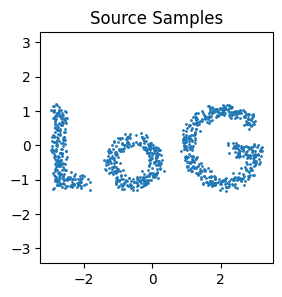

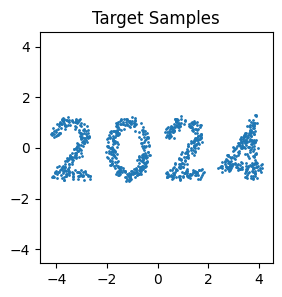

In [4]:
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt


def sample_points_from_mask(mask, num_samples=1000, sigma=0.05):
    # Get the indices of the pixels that are part of the letters
    letter_indices = np.argwhere(mask)

    # Uniformly sample points from these indices
    sampled_indices = letter_indices[np.random.choice(len(letter_indices), num_samples)]
    x = sampled_indices.astype(np.float32)
    x[:, 0] = -(x[:, 0] - mask.shape[0]//2) / (mask.shape[0]//8 )
    x[:, 1] = (x[:, 1] - mask.shape[1]//2) / (mask.shape[0]//8)
    x = np.flip(x,1)
    x = torch.tensor(x.astype('float32'))
    x = x + sigma * torch.randn_like(x)
    return x


# Load the mask
source_mask = Image.open(r'assets/log_conf.png')
source_mask = np.array(source_mask)
source_mask = (source_mask>0)[:,:,0]

# Load the mask
target_mask = Image.open(r'assets/2024.png')
target_mask = np.array(target_mask)
target_mask = (target_mask>0)[:,:,0]


source_samples = sample_points_from_mask(source_mask, num_samples=1000).numpy()
target_samples = sample_points_from_mask(target_mask, num_samples=1000).numpy()

def plot_x(xt_, title=''):
    plt.figure(figsize=(3,3))
    plt.scatter(xt_[:,0],xt_[:,1],s=1)
    plt.axis('equal')
    plt.title(title)
    plt.show()

plot_x(source_samples, title='Source Samples')
plot_x(target_samples, title='Target Samples')


## Conditional Flows

In [5]:
def CondOT_flow(x0, x1, t):
  xt = (1-t)*x0 + t*x1
  return xt

def CondOT_ut(x0, x1, t):
  cond_ut = x1-x0
  return cond_ut

## Training Loop

In [6]:
n_iters = 5000
batch_size = 5000

for iter in range(n_iters):

    optimizer.zero_grad()

    # sample t~U[0,1]
    t = torch.rand((batch_size,1)).to(device)

    # sample x0~p
    x0 = sample_points_from_mask(source_mask, num_samples=batch_size).to(device)

    # sample x1~q
    x1 = sample_points_from_mask(target_mask, num_samples=batch_size).to(device)

    # compute conditional affine flow
    # xt = psi_t(x0|x1) = sigma_t*x0 + alpha_t*x1
    xt = CondOT_flow(x0, x1, t)

    # compute conditional velocity
    # u_t(x|x1) = dsigma_t/dt*x0 + dalpha_t/dt*x1
    ut = CondOT_ut(x0, x1, t)

    # forward
    vt = model(xt,t)

    # loss
    loss = (vt - ut).pow(2).mean()

    # optimize
    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f'finished {iter} iterations')



finished 0 iterations
finished 1000 iterations
finished 2000 iterations
finished 3000 iterations
finished 4000 iterations


## Generate Samples

### ODE Solver - Euler

We implement [Euler Method](https://en.wikipedia.org/wiki/Euler_method) for numerically solving ODEs.

In [7]:
def Euler(ut, x_init, t_start=0., t_end=1., num_steps=100):
    xt = x_init
    t = t_start*torch.ones((xt.shape[0],1)).to(device)
    dt = (t_end-t_start)/num_steps

    with torch.no_grad():
      for i in range(num_steps):
        xt = xt + ut(xt,t) * dt
        t  = t + dt

    return xt

### Sample

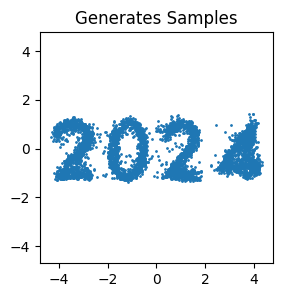

In [8]:
# sample from source distribution
x0 = sample_points_from_mask(source_mask, num_samples=5000).to(device)
t = torch.zeros((5000,1)).to(device)

# use Euler ODE solver to generate samples
xt = Euler(model, x0, t_start=0, t_end=1, num_steps=100)

plot_x(xt.detach().cpu().numpy(), title='Generates Samples')



## Sample and animate

In [9]:
x0 = sample_points_from_mask(source_mask, num_samples=5000).to(device)
t = torch.zeros((5000,1)).to(device)
xt = x0

N = 100
traj = []
with torch.no_grad():
    for i in range(N):

        vt = model(xt,t)
        xt = xt + vt/N
        t = t + 1/N

        if (i+1) % 2 ==0:
            xt_ = xt.cpu().numpy()
            traj.append(xt_)


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()

fig, ax = plt.subplots()
def animate(i):
    ax.cla()
    ax.scatter(traj[i][:,0],traj[i][:,1],s=1)
    ax.set_xlim(-4,4)
    ax.set_ylim(-1,1.5)
    ax.axis('off')
    ax.axis('equal')
    return fig
ani = animation.FuncAnimation(fig, animate, frames=50)
display(ani)

In [10]:
# Torus Flow Matching
Now we wrap the distributions on a torus

SyntaxError: invalid syntax (<ipython-input-10-46b1780cf254>, line 2)

# Torus Flow Matching

Now we transform this to distributions on the torus. We change the coordinate system to $\theta, \phi \in [0, 2 \pi]^2$.


In [18]:
import math

def sample_source(num_samples):
  source_samples = sample_points_from_mask(source_mask, num_samples=num_samples)
  source_samples += math.pi
  return source_samples

def sample_target(num_samples):

  target_samples = sample_points_from_mask(target_mask, num_samples=1000)
  target_samples = target_samples * 0.7 + math.pi
  return target_samples

plot_x(source_sample(1000), title='Source Samples')
plot_x(sample_target(1000), title='Target Samples')



tensor(0.1054) tensor(6.0317)


tensor([[0.3169, 2.5159],
        [5.8564, 3.9288],
        [1.8334, 3.0143],
        ...,
        [1.8390, 2.8712],
        [5.2089, 3.0246],
        [5.7737, 2.5771]])